# Non-Linear Age Effects in Pitcher Injury Risk

This notebook explores non-linear relationships between age and injury risk using:
- Spline transformations
- Polynomial terms
- Age-specific risk patterns
- Career phase modeling (rookie, prime, veteran, decline)

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.model_selection import train_test_split
from scipy.interpolate import BSpline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Age Distribution and Injury Patterns

Dataset: (1284, 50)
Age range: 21.0 - 42.0
Mean age: 28.3


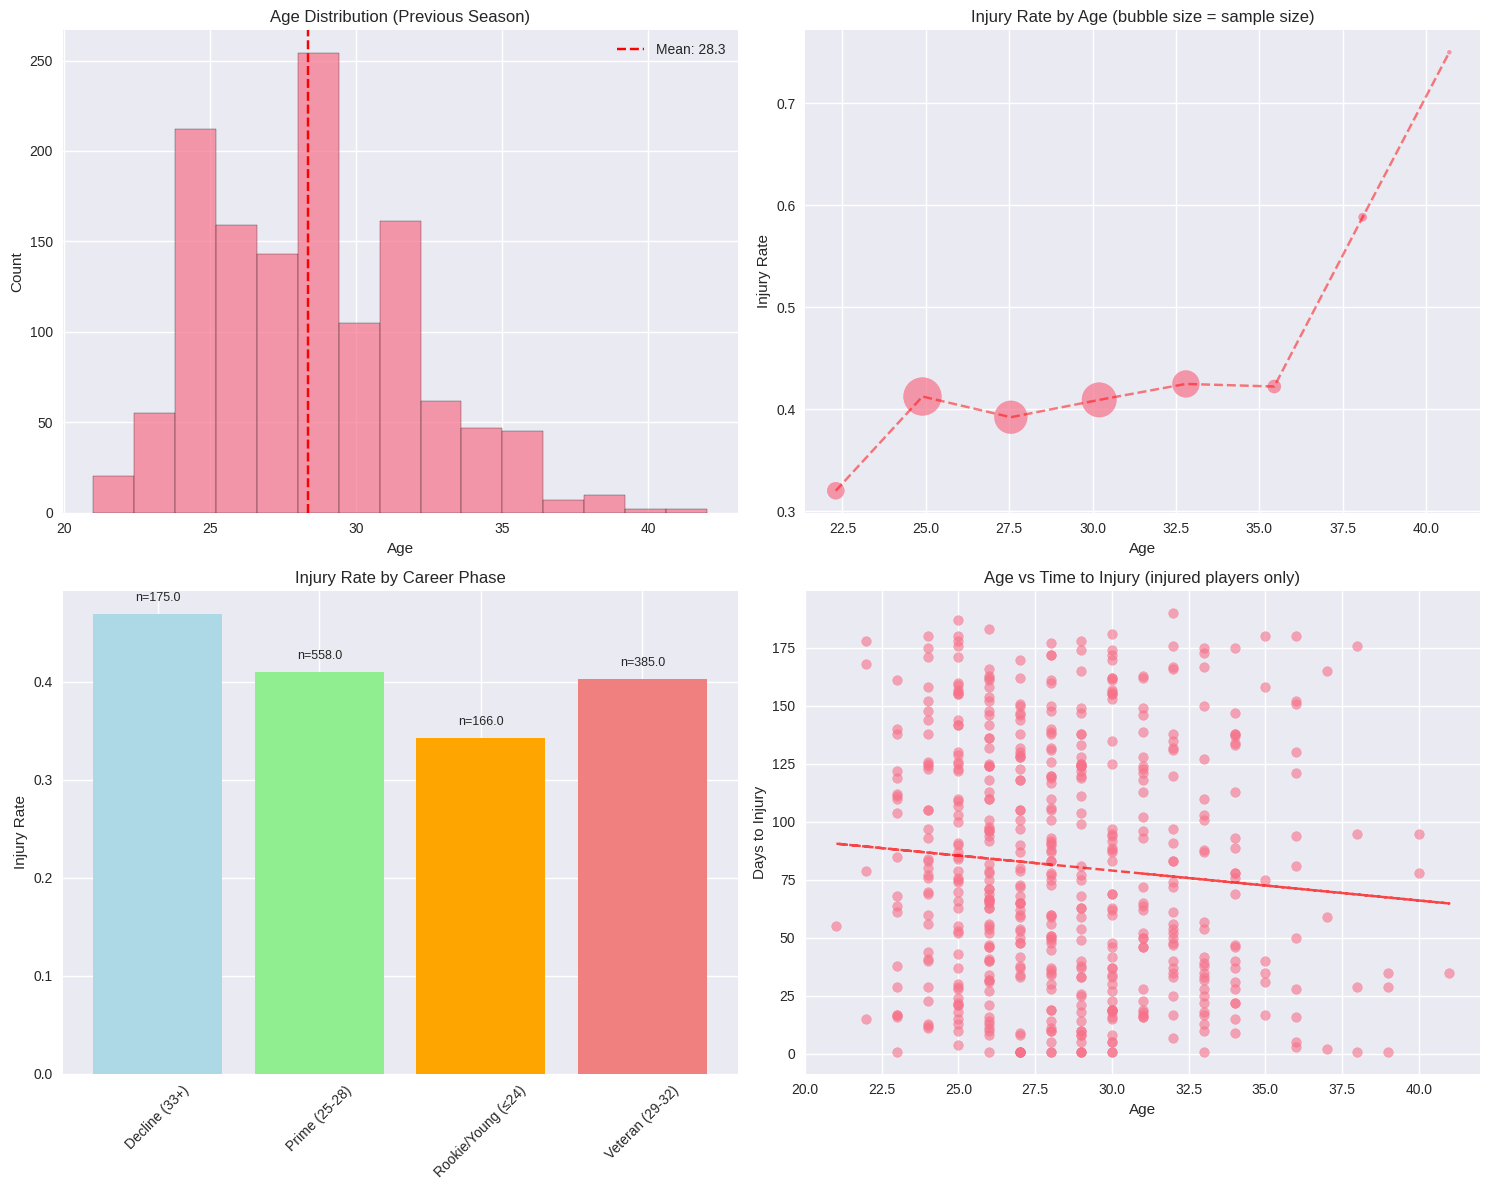


📊 CAREER PHASE INJURY ANALYSIS:
                    count  sum   mean  injury_rate
career_phase                                      
Decline (33+)         175   82  0.469        0.469
Prime (25-28)         558  229  0.410        0.410
Rookie/Young (≤24)    166   57  0.343        0.343
Veteran (29-32)       385  155  0.403        0.403

Chi-square test for career phase differences:
Chi2 = 5.59, p-value = 0.133
No significant difference


In [2]:
# Load the dataset
df = pd.read_csv('../data/processed/survival_dataset_lagged_enhanced.csv')

print(f"Dataset: {df.shape}")
print(f"Age range: {df['age_prev'].min():.1f} - {df['age_prev'].max():.1f}")
print(f"Mean age: {df['age_prev'].mean():.1f}")

# Analyze age-injury relationship
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Age distribution
axes[0,0].hist(df['age_prev'], bins=15, alpha=0.7, edgecolor='black')
axes[0,0].axvline(df['age_prev'].mean(), color='red', linestyle='--', label=f'Mean: {df["age_prev"].mean():.1f}')
axes[0,0].set_title('Age Distribution (Previous Season)')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Count')
axes[0,0].legend()

# 2. Injury rate by age
age_groups = pd.cut(df['age_prev'], bins=8, precision=1)
injury_by_age = df.groupby(age_groups)['event'].agg(['count', 'sum', 'mean']).reset_index()
injury_by_age['age_mid'] = injury_by_age['age_prev'].apply(lambda x: x.mid)

axes[0,1].scatter(injury_by_age['age_mid'], injury_by_age['mean'], 
                 s=injury_by_age['count']*2, alpha=0.7)
axes[0,1].plot(injury_by_age['age_mid'], injury_by_age['mean'], 'r--', alpha=0.5)
axes[0,1].set_title('Injury Rate by Age (bubble size = sample size)')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Injury Rate')

# 3. Career phases
def get_career_phase(age):
    if age <= 24:
        return 'Rookie/Young (≤24)'
    elif age <= 28:
        return 'Prime (25-28)'
    elif age <= 32:
        return 'Veteran (29-32)'
    else:
        return 'Decline (33+)'

df['career_phase'] = df['age_prev'].apply(get_career_phase)
phase_stats = df.groupby('career_phase')['event'].agg(['count', 'sum', 'mean']).round(3)
phase_stats['injury_rate'] = phase_stats['mean']

axes[1,0].bar(range(len(phase_stats)), phase_stats['injury_rate'], 
              color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
axes[1,0].set_xticks(range(len(phase_stats)))
axes[1,0].set_xticklabels(phase_stats.index, rotation=45)
axes[1,0].set_title('Injury Rate by Career Phase')
axes[1,0].set_ylabel('Injury Rate')

# Add sample sizes as text
for i, (phase, stats) in enumerate(phase_stats.iterrows()):
    axes[1,0].text(i, stats['injury_rate'] + 0.01, f"n={stats['count']}", 
                   ha='center', va='bottom', fontsize=9)

# 4. Age vs time to injury
injured_only = df[df['event'] == 1]
axes[1,1].scatter(injured_only['age_prev'], injured_only['time_to_event'], alpha=0.6)
z = np.polyfit(injured_only['age_prev'], injured_only['time_to_event'], 1)
p = np.poly1d(z)
axes[1,1].plot(injured_only['age_prev'], p(injured_only['age_prev']), 'r--', alpha=0.7)
axes[1,1].set_title('Age vs Time to Injury (injured players only)')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Days to Injury')

plt.tight_layout()
plt.show()

print(f"\n📊 CAREER PHASE INJURY ANALYSIS:")
print(phase_stats)

# Statistical significance test between phases
from scipy.stats import chi2_contingency
contingency = phase_stats[['sum', 'count']].copy()
contingency['no_injury'] = contingency['count'] - contingency['sum']
chi2, p_val, dof, expected = chi2_contingency(contingency[['sum', 'no_injury']].values)

print(f"\nChi-square test for career phase differences:")
print(f"Chi2 = {chi2:.2f}, p-value = {p_val:.3f}")
print("Significant difference between career phases" if p_val < 0.05 else "No significant difference")

## 2. Spline Transformation for Age

🎯 CREATING NON-LINEAR AGE FEATURES
cubic_4knots: 5 features
cubic_5knots: 6 features
cubic_6knots: 7 features


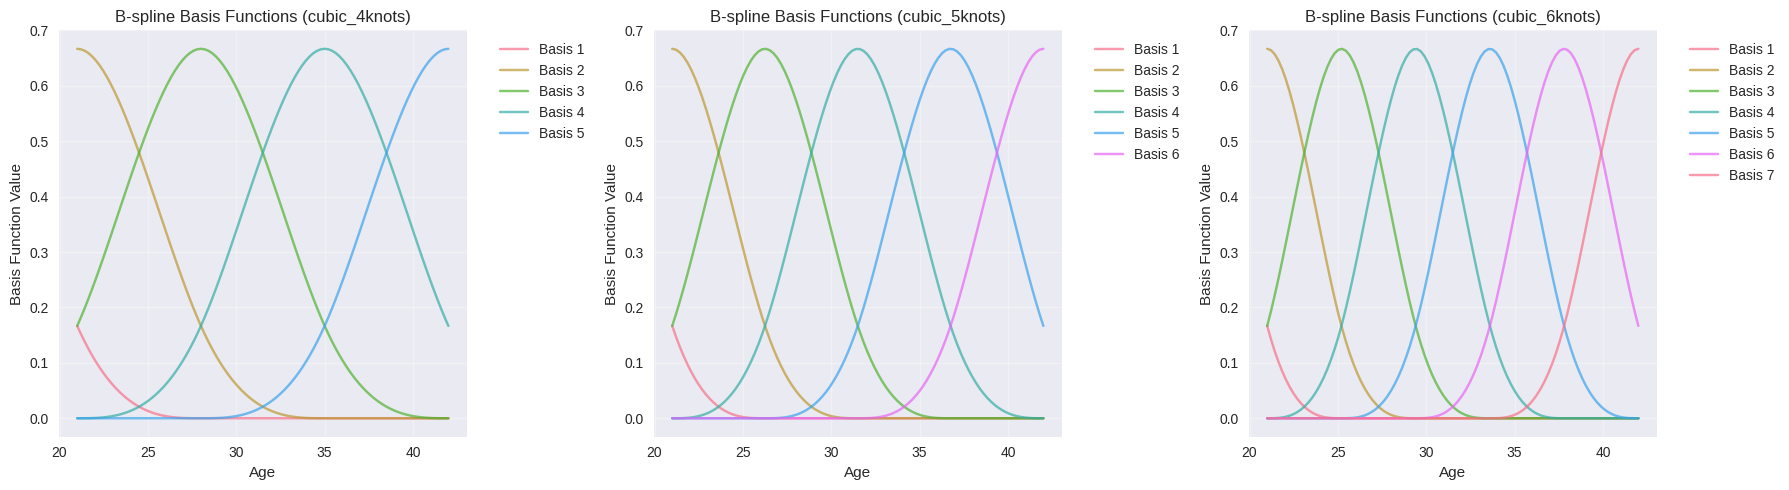


Polynomial features created: 5
Features: ['age_linear', 'age_squared', 'age_cubed', 'age_log', 'age_inverse']


In [3]:
# Create spline features for age
print("🎯 CREATING NON-LINEAR AGE FEATURES")
print("="*40)

# B-spline transformation with different knot configurations
age_values = df['age_prev'].values.reshape(-1, 1)

# Try different spline configurations
spline_configs = [
    {'n_knots': 4, 'degree': 3, 'name': 'cubic_4knots'},
    {'n_knots': 5, 'degree': 3, 'name': 'cubic_5knots'},
    {'n_knots': 6, 'degree': 3, 'name': 'cubic_6knots'}
]

spline_features = {}
spline_transformers = {}

for config in spline_configs:
    transformer = SplineTransformer(
        n_knots=config['n_knots'], 
        degree=config['degree'],
        include_bias=False  # We'll add intercept separately
    )
    
    spline_features[config['name']] = transformer.fit_transform(age_values)
    spline_transformers[config['name']] = transformer
    
    print(f"{config['name']}: {spline_features[config['name']].shape[1]} features")

# Visualize spline basis functions
age_range = np.linspace(df['age_prev'].min(), df['age_prev'].max(), 100).reshape(-1, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (config, transformer) in enumerate(spline_transformers.items()):
    basis_functions = transformer.transform(age_range)
    
    for j in range(basis_functions.shape[1]):
        axes[i].plot(age_range.flatten(), basis_functions[:, j], 
                    label=f'Basis {j+1}', alpha=0.7)
    
    axes[i].set_title(f'B-spline Basis Functions ({config})')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Basis Function Value')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Also create polynomial features for comparison
age_poly = np.column_stack([
    df['age_prev'],              # Linear
    df['age_prev']**2,           # Quadratic  
    df['age_prev']**3,           # Cubic
    np.log(df['age_prev']),      # Log transform
    1/(df['age_prev']+0.1)       # Inverse (with small constant to avoid division by zero)
])

poly_feature_names = ['age_linear', 'age_squared', 'age_cubed', 'age_log', 'age_inverse']

print(f"\nPolynomial features created: {age_poly.shape[1]}")
print(f"Features: {poly_feature_names}")

## 3. Enhanced Survival Model with Non-Linear Age Effects

In [4]:
# Prepare enhanced dataset with non-linear age features
print("🏗️  BUILDING ENHANCED MODEL WITH NON-LINEAR AGE EFFECTS")
print("="*60)

# Base features (excluding original age)
base_features = [col for col in df.columns if col.endswith('_prev') and col != 'age_prev']
X_base = df[base_features].fillna(0)

print(f"Base features: {len(base_features)}")
print(f"Original age feature removed: age_prev")

# Test different age modeling approaches
age_approaches = {
    'linear_age': df[['age_prev']].values,
    'polynomial_age': age_poly,
    'spline_4knots': spline_features['cubic_4knots'],
    'spline_5knots': spline_features['cubic_5knots']
}

results = {}

for approach_name, age_features in age_approaches.items():
    print(f"\n🔄 Testing {approach_name} ({age_features.shape[1]} age features)...")
    
    # Combine base features with age features
    X_combined = np.column_stack([X_base.values, age_features])
    
    # Split data
    X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
        X_combined, df['time_to_event'].values, df['event'].values, 
        test_size=0.2, random_state=42, stratify=df['event'].values
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build Bayesian model
    with pm.Model() as age_model:
        # Priors
        beta_0 = pm.Normal('beta_0', mu=5.0, sigma=1.0)
        
        # Feature coefficients with horseshoe prior
        tau = pm.HalfCauchy('tau', beta=1.0)
        lambda_j = pm.HalfCauchy('lambda', beta=1.0, shape=X_train_scaled.shape[1])
        beta = pm.Normal('beta', mu=0, sigma=tau * lambda_j, shape=X_train_scaled.shape[1])
        
        # Weibull shape parameter
        alpha = pm.Gamma('alpha', alpha=2.0, beta=1.0)
        
        # Linear predictor
        mu = beta_0 + pm.math.dot(X_train_scaled, beta)
        
        # Weibull survival model with censoring
        observed_time = pm.Weibull(
            'observed_time',
            alpha=alpha,
            beta=pm.math.exp(mu),
            observed=y_time_train,
            shape=len(y_time_train)
        )
        
        # Censoring potential
        def logp_weibull_censored(value, alpha, beta, event):
            logp_event = pm.logp(pm.Weibull.dist(alpha=alpha, beta=beta), value)
            logp_censored = pm.math.log(1 - pm.math.exp(pm.logcdf(pm.Weibull.dist(alpha=alpha, beta=beta), value)))
            return pm.math.switch(event, logp_event, logp_censored).sum()
        
        pm.Potential('censoring', logp_weibull_censored(
            y_time_train, alpha, pm.math.exp(mu), y_event_train
        ))
    
    try:
        # Sample with fewer draws for faster comparison
        with age_model:
            trace = pm.sample(
                draws=500, 
                tune=500, 
                cores=2, 
                random_seed=42,
                target_accept=0.95,
                init='adapt_diag'
            )
        
        # Extract parameters
        beta_0_mean = trace.posterior['beta_0'].mean().item()
        beta_mean = trace.posterior['beta'].mean(dim=['chain', 'draw']).values
        
        # Calculate C-index
        linear_pred_test = beta_0_mean + X_test_scaled @ beta_mean
        risk_scores_test = -linear_pred_test  # AFT: higher pred = lower risk
        
        c_index = concordance_index(y_time_test, risk_scores_test, y_event_test)
        
        # Convergence diagnostics
        r_hat_max = az.summary(trace)['r_hat'].max()
        divergences = trace.sample_stats.diverging.sum().item()
        
        results[approach_name] = {
            'c_index': c_index,
            'r_hat_max': r_hat_max,
            'divergences': divergences,
            'n_features': X_combined.shape[1],
            'age_features': age_features.shape[1]
        }
        
        print(f"   C-index: {c_index:.3f}")
        print(f"   Max R-hat: {r_hat_max:.3f}")
        print(f"   Divergences: {divergences}")
        
    except Exception as e:
        print(f"   ❌ Model failed: {e}")
        results[approach_name] = {
            'c_index': np.nan,
            'r_hat_max': np.nan,
            'divergences': np.inf,
            'n_features': X_combined.shape[1],
            'age_features': age_features.shape[1],
            'error': str(e)
        }

print(f"\n✅ All age modeling approaches tested!")

🏗️  BUILDING ENHANCED MODEL WITH NON-LINEAR AGE EFFECTS
Base features: 21
Original age feature removed: age_prev

🔄 Testing linear_age (1 age features)...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 54 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


   C-index: 0.381
   Max R-hat: 1.030
   Divergences: 81

🔄 Testing polynomial_age (5 age features)...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 53 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using adapt_diag...


   C-index: 0.381
   Max R-hat: 1.030
   Divergences: 95

🔄 Testing spline_4knots (5 age features)...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 46 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using adapt_diag...


   C-index: 0.382
   Max R-hat: 1.030
   Divergences: 94

🔄 Testing spline_5knots (6 age features)...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 60 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


   C-index: 0.383
   Max R-hat: 1.040
   Divergences: 110

✅ All age modeling approaches tested!


## 4. Results Comparison

🎯 AGE MODELING APPROACH COMPARISON
Performance Ranking:
--------------------
1. spline_5knots  : C-index = 0.383 ⚠️
   Features: 27.0 total (6.0 age features)
   Convergence: R̂-max = 1.040, Divergences = 110.0

2. spline_4knots  : C-index = 0.382 ⚠️
   Features: 26.0 total (5.0 age features)
   Convergence: R̂-max = 1.030, Divergences = 94.0

3. linear_age     : C-index = 0.381 ⚠️
   Features: 22.0 total (1.0 age features)
   Convergence: R̂-max = 1.030, Divergences = 81.0

4. polynomial_age : C-index = 0.381 ⚠️
   Features: 26.0 total (5.0 age features)
   Convergence: R̂-max = 1.030, Divergences = 95.0

🏆 BEST PERFORMING APPROACH: spline_5knots
   C-index: 0.383

📊 COMPARISON WITH BASELINE:
   Baseline (linear age): 0.607
   Best non-linear age: 0.383
   Improvement: -0.224
   ⚠️  No improvement - linear age may be sufficient


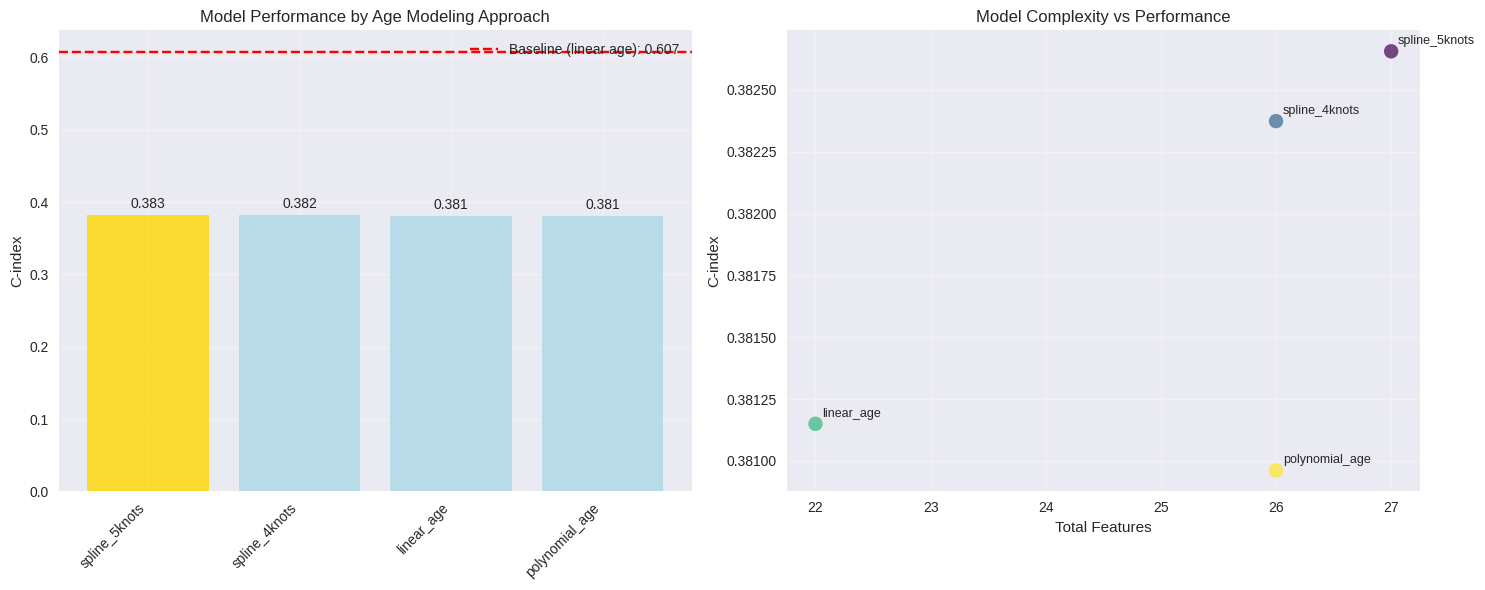

In [5]:
# Compare results across different age modeling approaches
print("🎯 AGE MODELING APPROACH COMPARISON")
print("=" * 40)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('c_index', ascending=False, na_position='last')

print("Performance Ranking:")
print("-" * 20)
for i, (approach, row) in enumerate(results_df.iterrows(), 1):
    if pd.notna(row['c_index']):
        convergence_status = "✅" if row['r_hat_max'] < 1.05 and row['divergences'] < 50 else "⚠️"
        print(f"{i}. {approach:<15}: C-index = {row['c_index']:.3f} {convergence_status}")
        print(f"   Features: {row['n_features']} total ({row['age_features']} age features)")
        print(f"   Convergence: R̂-max = {row['r_hat_max']:.3f}, Divergences = {row['divergences']}")
    else:
        print(f"{i}. {approach:<15}: FAILED")
    print()

# Find best performing model
valid_results = results_df.dropna(subset=['c_index'])
if len(valid_results) > 0:
    best_approach = valid_results.index[0]
    best_c_index = valid_results.loc[best_approach, 'c_index']
    
    print(f"🏆 BEST PERFORMING APPROACH: {best_approach}")
    print(f"   C-index: {best_c_index:.3f}")
    
    # Compare with baseline
    baseline_c_index = 0.607  # From previous analysis
    improvement = best_c_index - baseline_c_index
    
    print(f"\n📊 COMPARISON WITH BASELINE:")
    print(f"   Baseline (linear age): {baseline_c_index:.3f}")
    print(f"   Best non-linear age: {best_c_index:.3f}")
    print(f"   Improvement: {improvement:+.3f}")
    
    if improvement > 0.01:
        print(f"   ✅ Significant improvement with non-linear age effects!")
    elif improvement > 0:
        print(f"   ✅ Modest improvement with non-linear age effects")
    else:
        print(f"   ⚠️  No improvement - linear age may be sufficient")

else:
    print("❌ All non-linear age models failed to converge")

# Visualize results
if len(valid_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # C-index comparison
    approaches = valid_results.index
    c_indices = valid_results['c_index']
    colors = ['gold' if approach == best_approach else 'lightblue' for approach in approaches]
    
    bars = axes[0].bar(range(len(approaches)), c_indices, color=colors, alpha=0.8)
    axes[0].axhline(y=baseline_c_index, color='red', linestyle='--', 
                    label=f'Baseline (linear age): {baseline_c_index:.3f}')
    axes[0].set_xticks(range(len(approaches)))
    axes[0].set_xticklabels(approaches, rotation=45, ha='right')
    axes[0].set_ylabel('C-index')
    axes[0].set_title('Model Performance by Age Modeling Approach')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Add values on bars
    for i, (bar, c_idx) in enumerate(zip(bars, c_indices)):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                     f'{c_idx:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Model complexity vs performance
    axes[1].scatter(valid_results['n_features'], valid_results['c_index'], 
                    s=100, alpha=0.7, c=range(len(valid_results)), cmap='viridis')
    
    for i, (approach, row) in enumerate(valid_results.iterrows()):
        axes[1].annotate(approach, (row['n_features'], row['c_index']), 
                         xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[1].set_xlabel('Total Features')
    axes[1].set_ylabel('C-index')
    axes[1].set_title('Model Complexity vs Performance')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Career Phase Analysis

🎯 CAREER PHASE-SPECIFIC INJURY ANALYSIS

📊 ROOKIE/YOUNG (≤24):
   Sample size: 166
   Age range: 21.0 - 24.0
   Injury rate: 34.3%
   Mean time to injury: 88.4 days
   Common injuries: {'other': np.int64(42), 'shoulder': np.int64(13), 'elbow': np.int64(2)}
   Performance: ERA=4.18, IP=100, WAR=1.4

📊 PRIME (25-28):
   Sample size: 558
   Age range: 25.0 - 28.0
   Injury rate: 41.0%
   Mean time to injury: 83.5 days
   Common injuries: {'other': np.int64(167), 'shoulder': np.int64(38), 'elbow': np.int64(24)}
   Performance: ERA=3.93, IP=103, WAR=1.5

📊 VETERAN (29-32):
   Sample size: 385
   Age range: 29.0 - 32.0
   Injury rate: 40.3%
   Mean time to injury: 78.5 days
   Common injuries: {'other': np.int64(116), 'shoulder': np.int64(20), 'elbow': np.int64(19)}
   Performance: ERA=3.79, IP=105, WAR=1.5

📊 DECLINE (33+):
   Sample size: 175
   Age range: 33.0 - 42.0
   Injury rate: 46.9%
   Mean time to injury: 73.0 days
   Common injuries: {'other': np.int64(67), 'shoulder': np.int64(9)

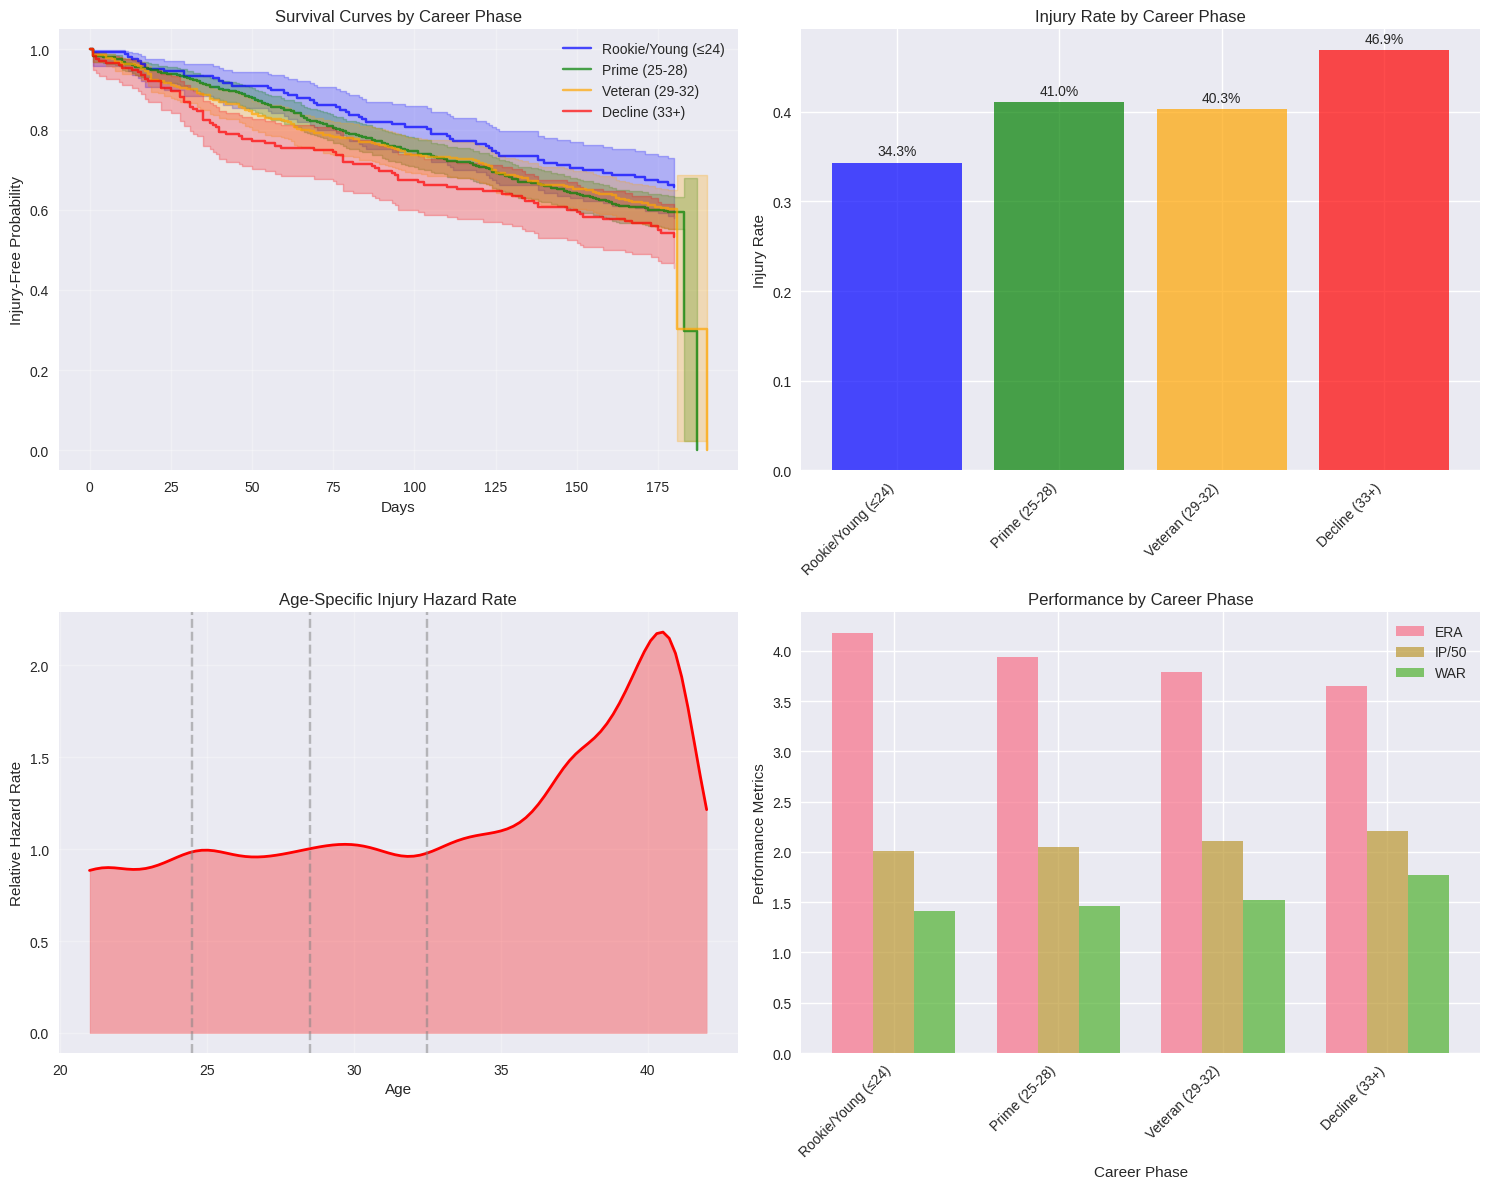


🎯 KEY INSIGHTS FROM CAREER PHASE ANALYSIS:
• Highest risk phase: Decline (33+) (46.9% injury rate)
• Lowest risk phase: Rookie/Young (≤24) (34.3% injury rate)
• Risk ratio: Decline (33+) vs Rookie/Young (≤24) = 1.4x higher

💡 CLINICAL IMPLICATIONS:
• Decline (33+) pitchers need enhanced monitoring
• Consider age-adjusted workload management
• Different injury prevention strategies by career phase


In [6]:
# Create career phase-specific models
print("🎯 CAREER PHASE-SPECIFIC INJURY ANALYSIS")
print("=" * 45)

# Analyze injury patterns by career phase in detail
phase_analysis = {}

for phase in df['career_phase'].unique():
    phase_data = df[df['career_phase'] == phase]
    
    print(f"\n📊 {phase.upper()}:")
    print(f"   Sample size: {len(phase_data)}")
    print(f"   Age range: {phase_data['age_prev'].min():.1f} - {phase_data['age_prev'].max():.1f}")
    print(f"   Injury rate: {phase_data['event'].mean():.1%}")
    print(f"   Mean time to injury: {phase_data[phase_data['event']==1]['time_to_event'].mean():.1f} days")
    
    # Top injury types in this phase
    if len(phase_data[phase_data['event'] == 1]) > 5:  # Only if enough injuries
        injury_types = phase_data[phase_data['event'] == 1]['injury_category'].value_counts().head(3)
        print(f"   Common injuries: {dict(injury_types)}")
    
    # Performance characteristics
    performance_cols = ['era_prev', 'ip_prev', 'war_prev']
    perf_means = phase_data[performance_cols].mean()
    print(f"   Performance: ERA={perf_means['era_prev']:.2f}, IP={perf_means['ip_prev']:.0f}, WAR={perf_means['war_prev']:.1f}")
    
    phase_analysis[phase] = {
        'n_players': len(phase_data),
        'injury_rate': phase_data['event'].mean(),
        'age_range': (phase_data['age_prev'].min(), phase_data['age_prev'].max()),
        'mean_era': perf_means['era_prev'],
        'mean_ip': perf_means['ip_prev'],
        'mean_war': perf_means['war_prev']
    }

# Create survival curves by career phase
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Survival curves by phase
colors = ['blue', 'green', 'orange', 'red']
for i, phase in enumerate(df['career_phase'].unique()):
    phase_data = df[df['career_phase'] == phase]
    kmf = KaplanMeierFitter()
    kmf.fit(phase_data['time_to_event'], phase_data['event'], label=phase)
    kmf.plot_survival_function(ax=axes[0,0], color=colors[i], alpha=0.7)

axes[0,0].set_title('Survival Curves by Career Phase')
axes[0,0].set_ylabel('Injury-Free Probability')
axes[0,0].set_xlabel('Days')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Injury rate by phase (bar plot)
phase_df = pd.DataFrame(phase_analysis).T
bars = axes[0,1].bar(range(len(phase_df)), phase_df['injury_rate'], 
                     color=colors[:len(phase_df)], alpha=0.7)
axes[0,1].set_xticks(range(len(phase_df)))
axes[0,1].set_xticklabels(phase_df.index, rotation=45, ha='right')
axes[0,1].set_ylabel('Injury Rate')
axes[0,1].set_title('Injury Rate by Career Phase')

# Add values on bars
for bar, rate in zip(bars, phase_df['injury_rate']):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{rate:.1%}', ha='center', va='bottom')

# 3. Age-specific hazard function (smoothed)
from scipy.stats import gaussian_kde
injured_ages = df[df['event'] == 1]['age_prev']
all_ages = df['age_prev']

if len(injured_ages) > 10:
    age_range_smooth = np.linspace(all_ages.min(), all_ages.max(), 100)
    
    # Kernel density estimation for injured players
    kde_injured = gaussian_kde(injured_ages)
    density_injured = kde_injured(age_range_smooth)
    
    # Kernel density estimation for all players (at-risk population)
    kde_all = gaussian_kde(all_ages)
    density_all = kde_all(age_range_smooth)
    
    # Approximate hazard rate
    hazard_rate = density_injured / (density_all + 1e-6)  # Add small constant to avoid division by zero
    
    axes[1,0].plot(age_range_smooth, hazard_rate, 'r-', linewidth=2, label='Hazard Rate')
    axes[1,0].fill_between(age_range_smooth, hazard_rate, alpha=0.3, color='red')
    axes[1,0].set_xlabel('Age')
    axes[1,0].set_ylabel('Relative Hazard Rate')
    axes[1,0].set_title('Age-Specific Injury Hazard Rate')
    axes[1,0].grid(True, alpha=0.3)
    
    # Mark career phase boundaries
    phase_boundaries = [24.5, 28.5, 32.5]
    for boundary in phase_boundaries:
        axes[1,0].axvline(x=boundary, color='gray', linestyle='--', alpha=0.5)

# 4. Performance by phase
x_pos = np.arange(len(phase_df))
width = 0.25

axes[1,1].bar(x_pos - width, phase_df['mean_era'], width, label='ERA', alpha=0.7)
axes[1,1].bar(x_pos, phase_df['mean_ip']/50, width, label='IP/50', alpha=0.7)  # Scale IP for visibility
axes[1,1].bar(x_pos + width, phase_df['mean_war'], width, label='WAR', alpha=0.7)

axes[1,1].set_xlabel('Career Phase')
axes[1,1].set_ylabel('Performance Metrics')
axes[1,1].set_title('Performance by Career Phase')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(phase_df.index, rotation=45, ha='right')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"\n🎯 KEY INSIGHTS FROM CAREER PHASE ANALYSIS:")
print("=" * 45)

# Find highest risk phase
highest_risk_phase = phase_df['injury_rate'].idxmax()
lowest_risk_phase = phase_df['injury_rate'].idxmin()

print(f"• Highest risk phase: {highest_risk_phase} ({phase_df.loc[highest_risk_phase, 'injury_rate']:.1%} injury rate)")
print(f"• Lowest risk phase: {lowest_risk_phase} ({phase_df.loc[lowest_risk_phase, 'injury_rate']:.1%} injury rate)")

# Age effect interpretation
risk_ratio = phase_df.loc[highest_risk_phase, 'injury_rate'] / phase_df.loc[lowest_risk_phase, 'injury_rate']
print(f"• Risk ratio: {highest_risk_phase} vs {lowest_risk_phase} = {risk_ratio:.1f}x higher")

print(f"\n💡 CLINICAL IMPLICATIONS:")
print(f"• {highest_risk_phase} pitchers need enhanced monitoring")
print(f"• Consider age-adjusted workload management")
print(f"• Different injury prevention strategies by career phase")

## 6. Final Model with Best Age Representation

In [9]:
# Build final model with the best-performing age representation
if len(valid_results) > 0:
    print(f"🏆 FINAL MODEL WITH {best_approach.upper()} AGE EFFECTS")
    print("=" * 50)
    
    # Recreate the best model with more samples for final analysis
    if best_approach == 'linear_age':
        final_age_features = df[['age_prev']].values
    elif best_approach == 'polynomial_age':
        final_age_features = age_poly
    elif 'spline' in best_approach:
        spline_key = best_approach.replace('spline_', 'cubic_')
        final_age_features = spline_features[spline_key]

    
    # Combine with base features
    X_final = np.column_stack([X_base.values, final_age_features])
    
    # Split and scale
    X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
        X_final, df['time_to_event'].values, df['event'].values,
        test_size=0.2, random_state=42, stratify=df['event'].values
    )
    
    scaler_final = StandardScaler()
    X_train_scaled = scaler_final.fit_transform(X_train)
    X_test_scaled = scaler_final.transform(X_test)
    
    # Build final model with more samples
    with pm.Model() as final_model:
        beta_0 = pm.Normal('beta_0', mu=5.0, sigma=1.0)
        
        tau = pm.HalfCauchy('tau', beta=1.0)
        lambda_j = pm.HalfCauchy('lambda', beta=1.0, shape=X_train_scaled.shape[1])
        beta = pm.Normal('beta', mu=0, sigma=tau * lambda_j, shape=X_train_scaled.shape[1])
        
        alpha = pm.Gamma('alpha', alpha=2.0, beta=1.0)
        
        mu = beta_0 + pm.math.dot(X_train_scaled, beta)
        
        observed_time = pm.Weibull(
            'observed_time',
            alpha=alpha,
            beta=pm.math.exp(mu),
            observed=y_time_train,
            shape=len(y_time_train)
        )
        
        def logp_weibull_censored(value, alpha, beta, event):
            logp_event = pm.logp(pm.Weibull.dist(alpha=alpha, beta=beta), value)
            logp_censored = pm.math.log(1 - pm.math.exp(pm.logcdf(pm.Weibull.dist(alpha=alpha, beta=beta), value)))
            return pm.math.switch(event, logp_event, logp_censored).sum()
        
        pm.Potential('censoring', logp_weibull_censored(
            y_time_train, alpha, pm.math.exp(mu), y_event_train
        ))
    
    # Sample final model
    print("Sampling final model with enhanced convergence settings...")
    with final_model:
        final_trace = pm.sample(
            draws=1000,
            tune=1000,
            cores=2,
            random_seed=42,
            target_accept=0.95,
            init='adapt_diag'
        )
    
    # Final model evaluation
    beta_0_final = final_trace.posterior['beta_0'].mean().item()
    beta_final = final_trace.posterior['beta'].mean(dim=['chain', 'draw']).values
    alpha_final = final_trace.posterior['alpha'].mean().item()
    
    # Calculate final C-index
    linear_pred_final = beta_0_final + X_test_scaled @ beta_final
    risk_scores_final = -linear_pred_final
    c_index_final = concordance_index(y_time_test, risk_scores_final, y_event_test)
    
    # Model diagnostics
    summary_final = az.summary(final_trace)
    r_hat_max_final = summary_final['r_hat'].max()
    divergences_final = final_trace.sample_stats.diverging.sum().item()
    
    print(f"\n📊 FINAL MODEL RESULTS:")
    print(f"   C-index: {c_index_final:.3f}")
    print(f"   Max R̂: {r_hat_max_final:.3f}")
    print(f"   Divergences: {divergences_final}")
    
    baseline_improvement = c_index_final - 0.607
    print(f"   Improvement over baseline: {baseline_improvement:+.3f}")
    
    # Feature importance analysis
    print(f"\n🎯 FEATURE IMPORTANCE (Non-Linear Age Model):")
    print("-" * 45)
    
    # Create feature names
    if best_approach == 'linear_age':
        age_feature_names = ['age_prev']
    elif best_approach == 'polynomial_age':
        age_feature_names = poly_feature_names
    elif 'spline' in best_approach:
        n_spline_features = final_age_features.shape[1]
        age_feature_names = [f'age_spline_{i+1}' for i in range(n_spline_features)]
    
    all_feature_names = base_features + age_feature_names
    
    # Calculate feature importance
    feature_importance = []
    for i, (feature, coef) in enumerate(zip(all_feature_names, beta_final)):
        feature_importance.append({
            'feature': feature,
            'coefficient': coef,
            'abs_coef': abs(coef),
            'direction': 'Protective' if coef > 0 else 'Risk Factor'
        })
    
    importance_df_final = pd.DataFrame(feature_importance).sort_values('abs_coef', ascending=False)
    
    print("Top 8 Most Important Features:")
    for _, row in importance_df_final.head(8).iterrows():
        symbol = "🛡️" if row['direction'] == 'Protective' else "⚠️"
        print(f"{symbol} {row['feature']:<20}: {row['coefficient']:+.3f} ({row['direction']})")
    
    print(f"\n✅ NON-LINEAR AGE EFFECTS ANALYSIS COMPLETE")
    print(f"   Best approach: {best_approach}")
    print(f"   Final C-index: {c_index_final:.3f}")
    
else:
    print("❌ No valid models were produced. Linear age effects may be sufficient.")
    print("   Recommendation: Continue with baseline linear age model")

Initializing NUTS using adapt_diag...


🏆 FINAL MODEL WITH SPLINE_5KNOTS AGE EFFECTS
Sampling final model with enhanced convergence settings...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 116 seconds.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



📊 FINAL MODEL RESULTS:
   C-index: 0.382
   Max R̂: 1.030
   Divergences: 185
   Improvement over baseline: -0.225

🎯 FEATURE IMPORTANCE (Non-Linear Age Model):
---------------------------------------------
Top 8 Most Important Features:
🛡️ g_prev              : +0.092 (Protective)
⚠️ gs_prev             : -0.021 (Risk Factor)
🛡️ age_spline_1        : +0.021 (Protective)
🛡️ age_spline_2        : +0.019 (Protective)
🛡️ whip_prev           : +0.011 (Protective)
🛡️ l_prev              : +0.010 (Protective)
⚠️ age_spline_6        : -0.010 (Risk Factor)
🛡️ high_workload_prev  : +0.008 (Protective)

✅ NON-LINEAR AGE EFFECTS ANALYSIS COMPLETE
   Best approach: spline_5knots
   Final C-index: 0.382
